##학습목표
- Backbone 모델을 원하는 레이어(layer)만큼 새로 학습시켜서 사용할 수 있다.
- Backbone 모델을 Transfer Learning 시킴으로써 원하는 이미지를 분류시킬 수 있다.
- 잘 학습된 모델을 저장하고, load할 수 있다.

In [1]:
# 라이브러리 import
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

# 데이터 가져오기
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name = 'cats_vs_dogs',
    split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir = "/content/drive/MyDrive/Colab Notebooks/2022/BOAZ/아이펠/4_data/",
    download = False,
    with_info = True,
    as_supervised=True,
)


# 리사이징할 이미지 크기
IMG_SIZE = 160

# 이미지를 같은 포맷으로 통일, 픽셀값의 scale 수정
def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE,IMG_SIZE))
  return image, label

# 원하는 모양의 데이터셋으로 변환
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# 한 스텝에 학습시킬 데이터의 개수
BATCH_SIZE = 32
# 학습 데이터를 적절히 섞어줄 사이즈
SHUFFLE_BUFFER_SIZE = 1000

# BATCH_SIZE에 따라 데이터를 랜덤으로 뽑아 제공
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

# 하나의 batch를 꺼내 확인
for image_batch, label_batch in train_batches.take(1):
  pass

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 사전학습된 VGG16 모델을 base_model 의 변수로 불러오기
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')

# Global Average Pooling 계층 만들기
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# 모델에 배치 넣기
feature_batch = base_model(image_batch)

# Global Average Pooling계층에 feature_batch 넣기
feature_batch_average = global_average_layer(feature_batch)

# Dense 레이어
dense_layer = tf.keras.layers.Dense(512, activation = 'relu')
prediction_layer = tf.keras.layers.Dense(2, activation = 'softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))

# base_model은 학습시키지 않음
base_model.trainable = False

# 최종 모델
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

print("슝~")

58900480/58889256 [==============================] - 0s 0us/step
슝~


모델 학습

optimizer, loss, metrics 준비해서 compile 하면 됨

In [2]:
base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics= ['accuracy'])

print("슝~")

슝~


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [3]:
# 초기 손실과 정확도 값 확인

validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 3s 86ms/step - loss: 0.7585 - accuracy: 0.4844
initial loss: 0.76
initial accuracy: 0.48


In [4]:
# 모델 학습 == 최종 성능

EPOCHS = 5

history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/5
582/582 [==============================] - 85s 141ms/step - loss: 0.2542 - accuracy: 0.9082 - val_loss: 0.1751 - val_accuracy: 0.9295
Epoch 2/5
582/582 [==============================] - 87s 145ms/step - loss: 0.1605 - accuracy: 0.9348 - val_loss: 0.1551 - val_accuracy: 0.9351
Epoch 3/5
582/582 [==============================] - 79s 132ms/step - loss: 0.1458 - accuracy: 0.9401 - val_loss: 0.1478 - val_accuracy: 0.9377
Epoch 4/5
582/582 [==============================] - 78s 131ms/step - loss: 0.1384 - accuracy: 0.9437 - val_loss: 0.1426 - val_accuracy: 0.9420
Epoch 5/5
582/582 [==============================] - 77s 130ms/step - loss: 0.1335 - accuracy: 0.9452 - val_loss: 0.1522 - val_accuracy: 0.9394


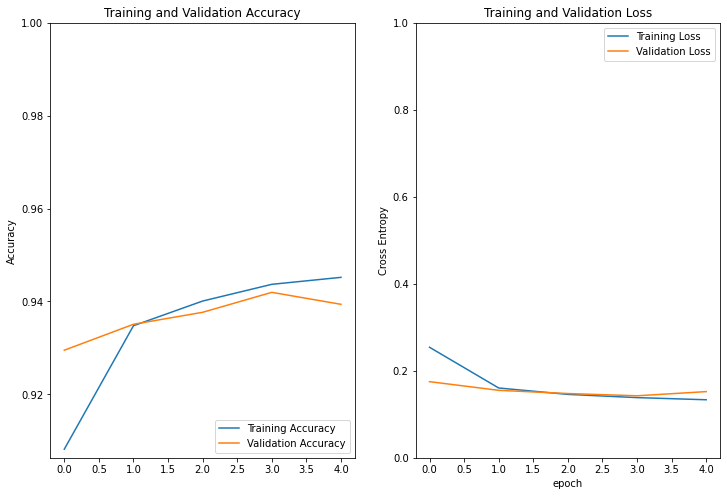

In [10]:
# 그래프로 학습 과정 살피기
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(acc,label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()